In [1]:
!nvidia-smi

Mon Jan  6 21:15:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77.01              Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti     On  |   00000000:01:00.0  On |                  N/A |
|  0%   30C    P8             14W /  240W |    2202MiB /   8192MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch, os, time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from src.Preprocessing import preprocessing_dataframe
from src.Tokenizer import MyTokenizer
from src.DataLoader import DataLoaderBert
from src.Model import MyBert
from src.Callback import EarlyStopping
from src.Training import model_train, model_eval

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_LABELS = 5
RANDOM_SEED = 23
VOCAB_PATH = "vocab_file.txt"


DATA_PATH = os.path.join("data", "datos.xlsx")
DATA_EXT_PATH = os.path.join("data", "reviews_ext.xlsx") 
DATA_SIN = os.path.join("data", "datos_sinonimos.xlsx")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_excel(DATA_PATH)
column_name_rev = df.columns.to_list()[len(df.columns.to_list())-1]
columns_to_keep = df.columns.to_list()[:2]

df_revisado = df[df[column_name_rev] == 'Revisado'][columns_to_keep]
df_revisado_eq = preprocessing_dataframe(df_revisado, False)
df_revisado.shape, df_revisado_eq.shape

((6052, 2), (2220, 2))

In [4]:
df_ext = pd.read_excel(DATA_SIN)[columns_to_keep]
df_ext_eq = preprocessing_dataframe(df_ext, False)

df_eq = pd.concat([df_revisado_eq, df_ext_eq], axis=0)

df_ext_eq.shape, df_eq.shape

((33015, 2), (35235, 2))

In [5]:
df_train , df_test = train_test_split(df_eq, test_size=0.3, random_state = RANDOM_SEED)
df_val , df_test = train_test_split(df_test, test_size=0.5, random_state = RANDOM_SEED)
len(df_train), len(df_val), len(df_test)

(24664, 5285, 5286)

In [6]:
tokenizer = MyTokenizer(VOCAB_PATH)
MAX_LEN = 512
BATCH_SIZE = 4

dataset_train_torch = DataLoaderBert(df_train['Review'].to_list(), df_train['Score_G'].to_list(),tokenizer, MAX_LEN)
train_dataloader = DataLoader(dataset_train_torch, batch_size=BATCH_SIZE, shuffle=True)

dataset_val_torch = DataLoaderBert(df_val['Review'].to_list(), df_val['Score_G'].to_list(),tokenizer, MAX_LEN)
val_dataloader = DataLoader(dataset_val_torch, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
VOCAB_SIZE = 20000
DROPOUT = 0.1
EMBED_DIM , ATT_HEADS, D_FF = 768, 12, 3072

model = MyBert(VOCAB_SIZE, MAX_LEN, EMBED_DIM, ATT_HEADS, D_FF, DROPOUT, NUM_LABELS, device, N=1).to(device)
model

MyBert(
  (token_embed): Embedding(20000, 768, padding_idx=0)
  (pos_encod): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0): MyBertLayer(
      (att): MultiHeadAttention(
        (q_linear): Linear(in_features=768, out_features=768, bias=True)
        (k_linear): Linear(in_features=768, out_features=768, bias=True)
        (v_linear): Linear(in_features=768, out_features=768, bias=True)
        (weights_out): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (relu): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop1): Dropout(p=0.1, inplace=False)
      (drop2): Dropout(p=0.1, inplace=False)
    )
  )
  (layerNorm): LayerNor

In [8]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
train_loss, train_acc, val_loss, val_acc = [], [], [], []
best_acc = 0
best_hist = []
early_stopping = EarlyStopping()

inicio = time.perf_counter()
num_epochs = 1000
for epoch in range(num_epochs): 
    train_loss_epoch, train_acc_epoch = model_train(model, train_dataloader, loss_fn, optimizer, len(df_train), device)
    train_loss.append(train_loss_epoch)
    train_acc.append(train_acc_epoch)

    val_loss_epoch, val_acc_epoch, hist_acc = model_eval(model, val_dataloader, loss_fn, len(df_val), device)
    val_loss.append(val_loss_epoch)
    val_acc.append(val_acc_epoch)

    print(f"Num epoch: {epoch+1}, Train_loss: {train_loss_epoch}")
    
    if val_acc_epoch > best_acc:
        best_acc = val_acc_epoch
        best_hist = hist_acc
        
    if early_stopping(val_loss_epoch, model):
        break

final = time.perf_counter()
print("-"*30)
res_model = {
    'Time': int(round(final - inicio,2)/60),
    'Train_loss': sorted(train_loss)[0],
    'Train_acc': sorted(train_acc, reverse=True)[0].item(),
    'Val_loss': sorted(val_loss)[0],
    'Val_acc': sorted(val_acc, reverse=True)[0].item()
}
res_model

Num epoch: 1, Train_loss: 1.5777640557215658
Num epoch: 2, Train_loss: 1.5494513882084247
Num epoch: 3, Train_loss: 1.544439649353776
Num epoch: 4, Train_loss: 1.532892762744655
Num epoch: 5, Train_loss: 1.5291077771377841
Num epoch: 6, Train_loss: 1.5274585621661658
Num epoch: 7, Train_loss: 1.5175149577741998
Num epoch: 8, Train_loss: 1.517257059399586
Num epoch: 9, Train_loss: 1.5102644743681186
Num epoch: 10, Train_loss: 1.4926409698271186
Num epoch: 11, Train_loss: 1.5017277839854286
Num epoch: 12, Train_loss: 1.5014547459633754
Num epoch: 13, Train_loss: 1.4976081575254632
Num epoch: 14, Train_loss: 1.4907226980969845
Num epoch: 15, Train_loss: 1.4886128915001964
Num epoch: 16, Train_loss: 1.4775714286437793
Num epoch: 17, Train_loss: 1.4556103829358484
Num epoch: 18, Train_loss: 1.4396088965916223
Num epoch: 19, Train_loss: 1.4372473149293048
Num epoch: 20, Train_loss: 1.420548696835784
Num epoch: 21, Train_loss: 1.4152832486942541
Num epoch: 22, Train_loss: 1.3950521319650266
N

{'Time': 173,
 'Train_loss': 0.7124361057947768,
 'Train_acc': 0.7191858291625977,
 'Val_loss': 0.9639762940516473,
 'Val_acc': 0.6643330454826355}

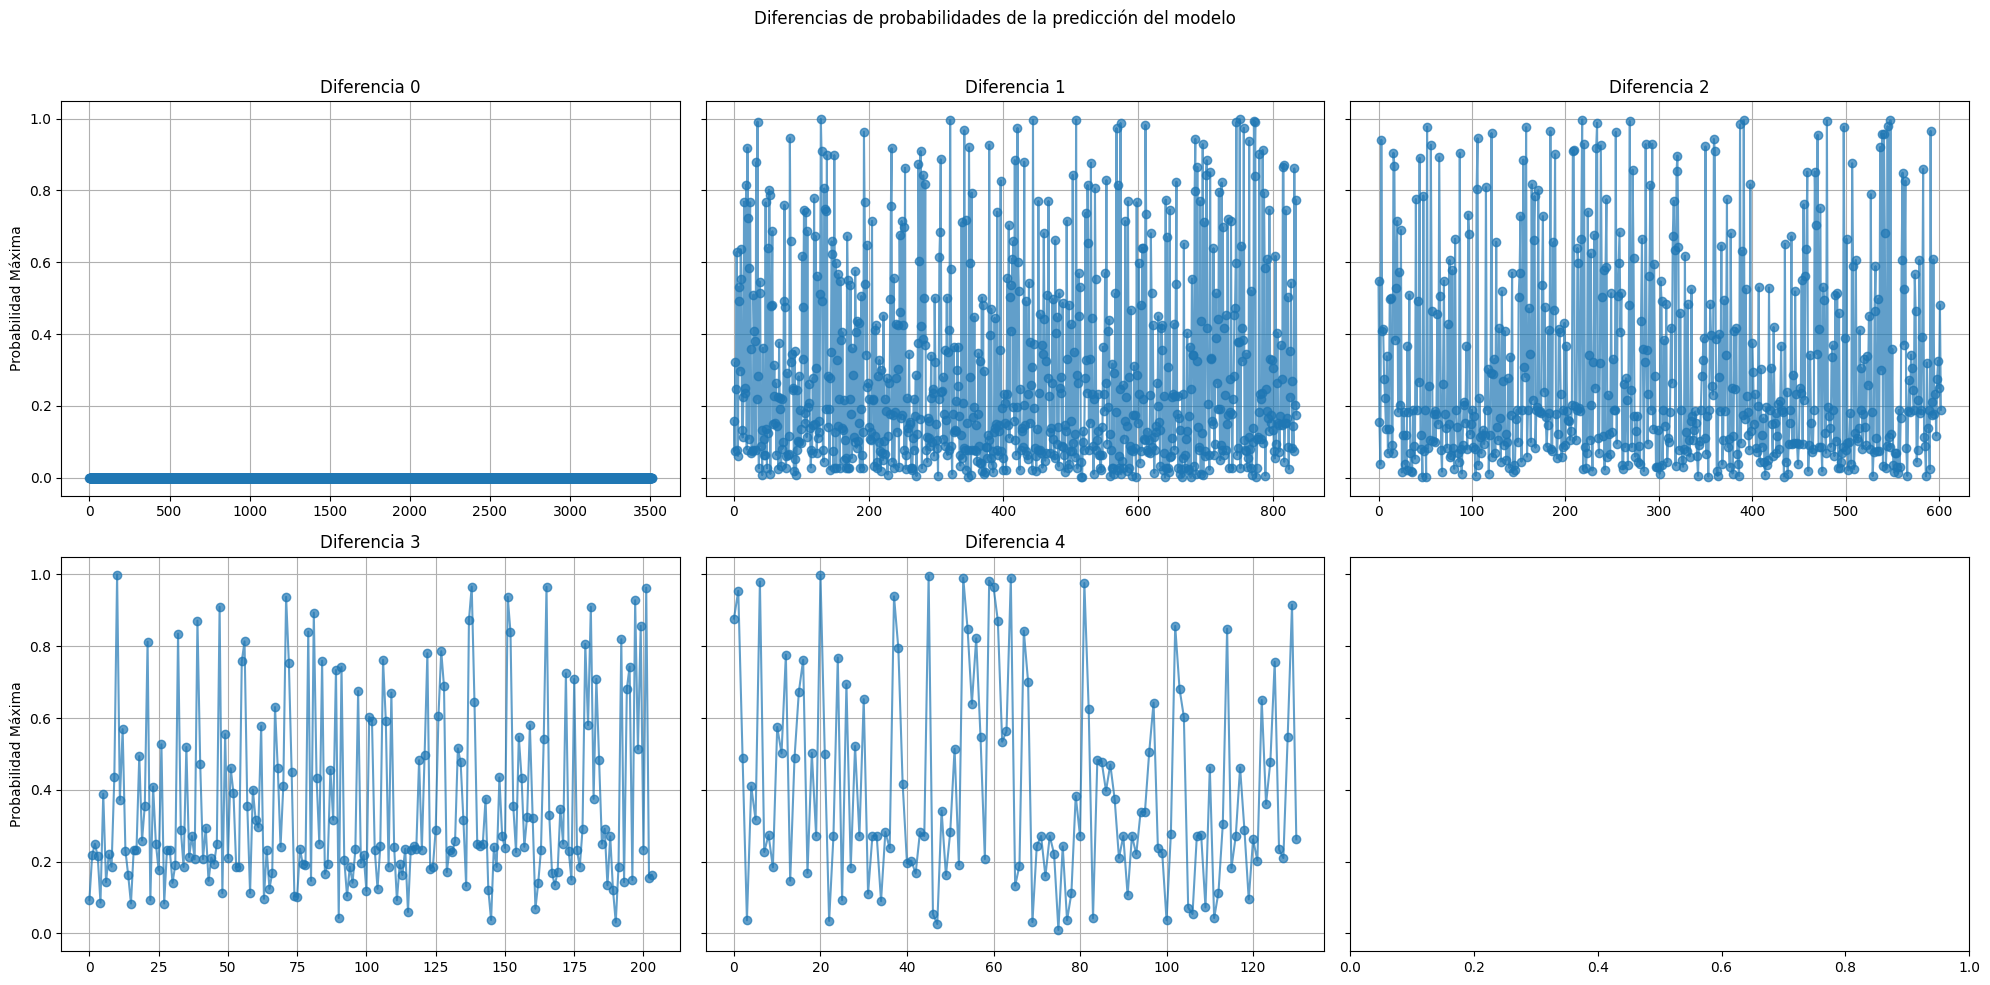

In [9]:
diferencias = [dif for dif, _ in best_hist]
softmax_values = [prob for _, prob in best_hist]
name_pos_dif = [0, 1, 2, 3, 4]

fig, axs = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
fig.suptitle('Diferencias de probabilidades de la predicción del modelo')

r = 0
for i, pos_dif in enumerate(name_pos_dif):
    
    if i >= 3:
        r = 1
        i -= 3

    indices_dif = [idx for idx, valor in enumerate(diferencias) if valor == pos_dif]
    values_dif = [softmax_values[idx] for idx in indices_dif]

    indices = range(len(values_dif))
    axs[r][i].plot(indices, values_dif, marker='o', label=f'{pos_dif}', alpha=0.7, linestyle='-', markersize=6)
    
    axs[r][i].set_title(f'Diferencia {3*r + i}')
    axs[r][i].grid(True)


axs[0][0].set_ylabel('Probabilidad Máxima')
axs[1][0].set_ylabel('Probabilidad Máxima')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [10]:
name_model = 'bestMyBert.bin'
torch.save(model.state_dict(), os.path.join('model', name_model))